In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Log time
import time
start_time = time.time()

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # for plotting
import seaborn as sns; sns.set() # for plotting 
from IPython.display import display
import warnings
warnings.filterwarnings("ignore") # To ignore warning messages while executing the code.

import tqdm
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

# Data preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# SK-learn libraries for evaluation.
from sklearn import metrics 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# NLP libraries
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import spacy

# Deep Learning frameworks
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model


import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.


['log-regsav', 'glove6b', 'glove-global-vectors-for-word-representation', 'jigsaw-unintended-bias-in-toxicity-classification', 'glove-twitter-27b-200d-txt']


Using TensorFlow backend.


## 1. Import Data

In [2]:
data = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv")
test_data = pd.read_csv("../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv")
print('data shape:', data.shape)
print('test_data shape:',test_data.shape)

data shape: (1804874, 45)
test_data shape: (97320, 2)


## 2. Preprocessing

### 2.1 Convert Labels to Boolean

In [3]:
data['comment_text'] = data['comment_text'].astype(str) 
data_columns = data.columns
#identity_columns = list(data_columns[8:32])

identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
    df[col_name] = np.where(df[col_name] >= 0.5, 1, 0)
    
def convert_dataframe_to_bool(df):
    bool_df = df.copy()
    for col in ['target'] + identity_columns:
        convert_to_bool(bool_df, col)
    return bool_df

data_boolean = convert_dataframe_to_bool(data)
data_boolean.head(3)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0,This is such an urgent design problem; kudos t...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4


[Text(0, 0.5, 'frequency'), Text(0.5, 0, 'target')]

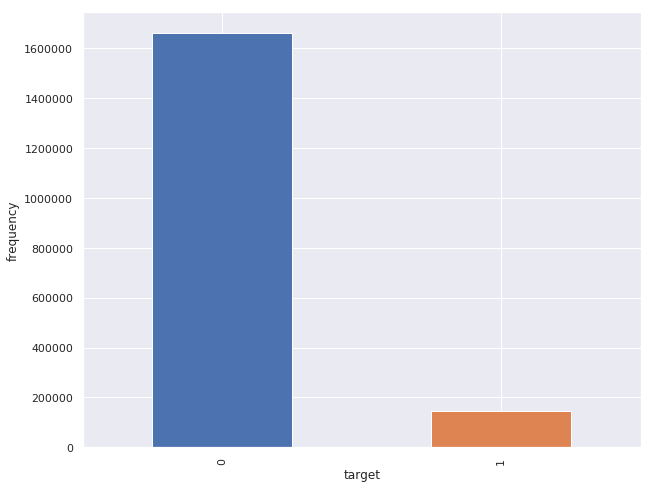

In [4]:
# Check out targets as boolean data. 
target = data_boolean['target']
fig_std=(10,8)
width = 0.4
target.value_counts().plot(kind='bar', figsize=fig_std).set(xlabel='target', ylabel='frequency') # To see the distribution of 'target' in the data

In [5]:
lens = data_boolean.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(297.2343266067327, 269.1966399585827, 1906)

In [6]:
#data_boolean.groupby('target').black.hist(bins='fd')
with open('comment.txt', 'w') as f:
    f.writelines(['\n', str(data_boolean['comment_text'])])
    
data_boolean.to_csv('comment.csv')

### 2.2 Add Features

In [7]:
def data_preprocess(df):
    preprocessed_data = df.copy()
    # Feature 1: Length of sentence
    preprocessed_data['sentence_length'] = preprocessed_data['comment_text'].apply(sent_tokenize).apply(len)
    # Feature 2: Length of words
    preprocessed_data['word_length'] = preprocessed_data['comment_text'].apply(word_tokenize).apply(len)
    # Feature 3: Words per sentence
    preprocessed_data['words_per_sentence'] = preprocessed_data['word_length'] / preprocessed_data['sentence_length']   
    return preprocessed_data


In [8]:

preprocessed_data_boolean = data_preprocess(data_boolean)


In [9]:
preprocessed_data_boolean.head(5)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,sentence_length,word_length,words_per_sentence
0,59848,0,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,3,27,9.000000
1,59849,0,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,3,28,9.333333
2,59852,0,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,2,19,9.500000
3,59855,0,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,0,NaN,0,0,NaN,NaN,0,NaN,0,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,2,20,10.000000
4,59856,1,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0,0.0,0,0,0.0,0.0,0,0.25,0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47,1,9,9.000000


## 3. Train Model

### Split Data

In [10]:
X, y = data_boolean["comment_text"], data_boolean["target"]
train_data, dev_data, train_labels, dev_labels = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)
print('train_data shape: ',train_data.shape)
print('train_labels shape: ',train_labels.shape)
print('dev_data shape: ',dev_data.shape)
print('dev_labels shape: ',dev_labels.shape)

train_data shape:  (1443899,)
train_labels shape:  (1443899,)
dev_data shape:  (360975,)
dev_labels shape:  (360975,)


In [11]:
train_data[1]

"Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!"

### Tokenize 

In [12]:
MAX_NUM_WORDS = 10000
TOXICITY_COLUMN = 'target'
TEXT_COLUMN = 'comment_text'

# Create a text tokenizer.
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(data_boolean[TEXT_COLUMN])

# All comments must be truncated or padded to be the same length.
MAX_SEQUENCE_LENGTH = 250
def pad_text(texts, tokenizer):
    return pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_SEQUENCE_LENGTH)

### Model - Tfidf 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression


train_vectorizer = TfidfVectorizer()
train_vectors = train_vectorizer.fit_transform(train_data)

dev_vectorizer = TfidfVectorizer()
dev_vectorizer.fit(train_data)
dev_vectors = dev_vectorizer.transform(dev_data)   

In [14]:

# Get R ratio
log_reg = LogisticRegression(C=100)
log_reg.fit(train_vectors, train_labels)
y_pred = log_reg.predict(dev_vectors)
print("==============================================")
tf_f1 = round(metrics.f1_score(dev_labels, y_pred, average="macro"),3)
print("F1 score of Logistic Regression using TfidfVectorizer: " + str(tf_f1))
print("==============================================")
print("\n")



F1 score of Logistic Regression using TfidfVectorizer: 0.784




In [15]:
pre_prob = log_reg.predict_proba(dev_vectors)
R_list = []


In [16]:
dev_data = list(dev_data)
dev_labels = list(dev_labels)

In [17]:

for i in range(len(y_pred)):
    max_pred = max(pre_prob[i])
    correct_pred = pre_prob[i][dev_labels[i]]
    R_list.append(max_pred/correct_pred)



In [18]:
# Get the top 3 documents where R was largest. This means that it had a high confidence in its predicted 
# probability and a low probability of predicting for the correct label
categories = ['not-toxic', 'toxic']

top_3 = np.argpartition(R_list, -3)[-3:]
top_3 = list(top_3)
top_3.reverse()
for pos, t in enumerate(top_3):
    print("==============================================")
    print("#" + str(pos+1) + " Highest R Document")
    print("True category = " + str(categories[dev_labels[t]]))
    print("Predicted category = " + str(categories[y_pred[t]]))
    print("==============================================")
    print(dev_data[t])     

#1 Highest R Document
True category = not-toxic
Predicted category = toxic
You know. Morons.
#2 Highest R Document
True category = not-toxic
Predicted category = toxic
Moron extrodinare
#3 Highest R Document
True category = not-toxic
Predicted category = toxic
MinORityofONe...Moron?


## 5. Error Analysis

### ROC

AUC: 0.926


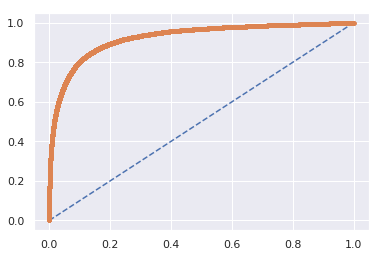

In [19]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# keep probabilities for the positive outcome only
pos_probs = pre_prob[:, 1]

# calculate AUC
auc = roc_auc_score(dev_labels, pos_probs)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(dev_labels, pos_probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

### Precision & Recall

In [20]:
# Precision-Recall curves should be used when there is a moderate to large class imbalance.

# The main reason for this optimistic picture is because of the use of true negatives in the False Positive Rate in the ROC Curve and the careful avoidance of this rate in the Precision-Recall curve.




f1=0.599 auc=0.673 ap=0.673


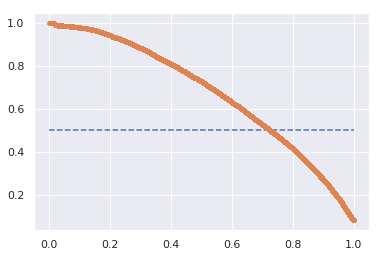

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

probs = log_reg.predict_proba(dev_vectors)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# predict class values
yhat = log_reg.predict(dev_vectors)
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(dev_labels, probs)
# calculate F1 score
f1 = f1_score(dev_labels, yhat)
# calculate precision-recall AUC
auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(dev_labels, probs)
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()

##  7. Save Files

In [22]:
import pickle
filename = 'log_reg_vector_classifier.sav'
pickle.dump(log_reg, open(filename, 'wb'), protocol=2)


In [23]:
len(tpr)

32846

In [24]:
# Write out preprocessed boolean data
data_boolean.to_csv('data_boolean.csv', index=False)